In [ ]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 42

FILENAME = "train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
# print("EX1) #Righe: " + str(df1.shape[0])+ " #Colonne: "+str(df1.shape[1]))

# print(df1.nunique())
# print(df1.isna().sum())

# print(df1.shape)
df1 = df1.dropna()
# print(df1.shape)


y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()

for feature in ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_version","ssl_cipher","ssl_resumed","ssl_established","ssl_subject","ssl_issuer","http_trans_depth","http_method","http_uri","http_referrer","http_version","http_request_body_len","http_response_body_len","http_status_code","http_user_agent","http_orig_mime_types","http_resp_mime_types","weird_name","weird_addl","weird_notice"]:
    # print(f"Feature: {feature}")    
    feature_index = np.where(df1.columns == feature)[0][0]
    elements, counts = np.unique(X[:, feature_index], return_counts=True)

    # for element, count in zip(elements, counts):
    #     print(f"    Element: {element}, Count: {count}")


oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


# variances = np.var(X, axis=0)
# features = df1.columns
# for i, variance in enumerate(variances):
#     print(f"{features[i]} \t\t: Variance = {variance}")


from sklearn.feature_selection import VarianceThreshold

# selector = VarianceThreshold(0.01)
selector = VarianceThreshold(0.01)
X_mod = selector.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"Modified shape: {X_mod.shape}")

indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=seed)
# test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1

ps = PredefinedSplit(fold)
ps.get_n_splits()

y_test = y[test_idx]
y_train = y[train_idx]
# y_val = y[val_idx]

X_test_mod = X_mod[test_idx,:]
X_train_mod = X_mod[train_idx,:]
# X_val_mod = X_mod[val_idx,:]

X_test = X[test_idx,:]
X_train = X[train_idx,:]
# X_val = X[val_idx,:]

print(X_train.shape, X_test.shape)
print(X_train_mod.shape, X_test_mod.shape)
print(len(y_train), len(y_test))


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import decomposition

## Scaling (treshold)
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_mod)
X_train_mod = scaler.transform(X_train_mod)
X_test_mod = scaler.transform(X_test_mod)

## Scaling (no treshold)
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)
print(X_train_mod.shape, X_test_mod.shape)


## PCA (treshold)
pca = decomposition.PCA()
pca.fit(X_train_mod)
X_train_mod_pca = pca.transform(X_train_mod)
X_test_mod_pca = pca.transform(X_test_mod)

## PCA (no treshold)
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape, X_test_pca.shape)
print(X_train_mod_pca.shape, X_test_mod_pca.shape)


## LDA (treshold)
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train_mod, y_train)
X_train_mod_lda = lda.transform(X_train_mod)
X_test_mod_lda = lda.transform(X_test_mod)

## LDA (no treshold)
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

X_train_std = X_train
X_test_std = X_test

print(X_train_lda.shape, X_test_lda.shape)
print(X_train_mod_lda.shape, X_test_mod_lda.shape)

print("---")
for i, (train_idx, test_idx) in enumerate(ps.split()):
    print(f"Fold {i}:")
    print(f"  Train: index={train_idx}")
    print(f"  Test:  index={test_idx}")




Original shape: (616983, 44)
Modified shape: (616983, 28)
(555284, 44) (61699, 44)
(555284, 28) (61699, 28)
555284 61699
(555284, 44) (61699, 44)
(555284, 28) (61699, 28)
(555284, 44) (61699, 44)
(555284, 28) (61699, 28)
(555284, 9) (61699, 9)
(555284, 9) (61699, 9)
---
Fold 0:
  Train: index=[     0      1      2 ... 616980 616981 616982]
  Test:  index=[     3     23     66 ... 616924 616971 616977]


In [13]:
print(pd.merge(pd.DataFrame(X_train), pd.DataFrame(X_test), how='inner'))
print(pd.merge(pd.DataFrame(X_train_mod), pd.DataFrame(X_test_mod), how='inner'))
print(pd.merge(pd.DataFrame(X_train_pca), pd.DataFrame(X_test_pca), how='inner'))
print(pd.merge(pd.DataFrame(X_train_mod_pca), pd.DataFrame(X_test_mod_pca), how='inner'))
print(pd.merge(pd.DataFrame(X_train_lda), pd.DataFrame(X_test_lda), how='inner'))
print(pd.merge(pd.DataFrame(X_train_mod_lda), pd.DataFrame(X_test_mod_lda), how='inner'))

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Index: []

[0 rows x 44 columns]
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Index: []

[0 rows x 28 columns]
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Index: []

[0 rows x 44 columns]
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Index: []

[0 rows x 28 columns]
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Index: []
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Index: []


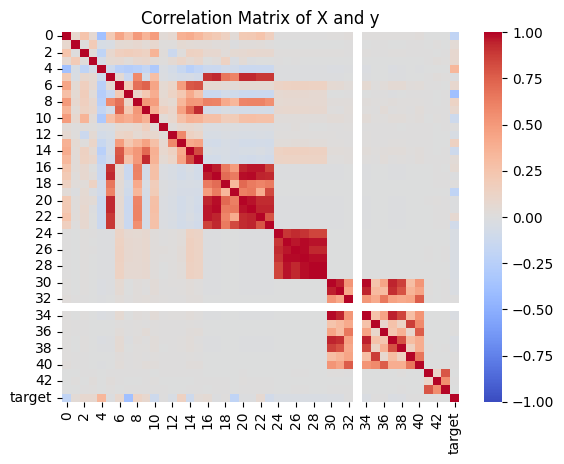

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt

# Combine X and y into a single DataFrame
data = pd.DataFrame(X)
data['target'] = y

# Compute the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of X and y')
plt.show()

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm

import pickle

In [3]:
## KNN + threshold

param_grid = {
    'n_neighbors': [10,20,50,100,500,775,900,1000,1500,2000],
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, verbose=10)
grid.fit(X_mod, y)
file = open("knn_extreme.save", "wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
file.close()

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV 1/1; 1/10] START n_neighbors=10.............................................
[CV 1/1; 1/10] END ..............n_neighbors=10;, score=0.991 total time=   2.1s
[CV 1/1; 2/10] START n_neighbors=20.............................................
[CV 1/1; 2/10] END ..............n_neighbors=20;, score=0.989 total time=   2.3s
[CV 1/1; 3/10] START n_neighbors=50.............................................
[CV 1/1; 3/10] END ..............n_neighbors=50;, score=0.986 total time=   3.1s
[CV 1/1; 4/10] START n_neighbors=100............................................
[CV 1/1; 4/10] END .............n_neighbors=100;, score=0.984 total time=   4.0s
[CV 1/1; 5/10] START n_neighbors=500............................................
[CV 1/1; 5/10] END .............n_neighbors=500;, score=0.973 total time=  11.3s
[CV 1/1; 6/10] START n_neighbors=775............................................
[CV 1/1; 6/10] END .............n_neighbors=775;

In [6]:
## KNN

param_grid = {
    'n_neighbors': [10,20,50,100,500,775,900,1000,1500,2000],
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=ps, verbose=10)
grid.fit(X, y)
file = open("knn2.save", "wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
file.close()

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV 1/1; 1/10] START n_neighbors=10.............................................
[CV 1/1; 1/10] END ..............n_neighbors=10;, score=0.991 total time=  28.1s
[CV 1/1; 2/10] START n_neighbors=20.............................................
[CV 1/1; 2/10] END ..............n_neighbors=20;, score=0.989 total time=  28.0s
[CV 1/1; 3/10] START n_neighbors=50.............................................
[CV 1/1; 3/10] END ..............n_neighbors=50;, score=0.986 total time=  28.4s
[CV 1/1; 4/10] START n_neighbors=100............................................
[CV 1/1; 4/10] END .............n_neighbors=100;, score=0.984 total time=  29.2s
[CV 1/1; 5/10] START n_neighbors=500............................................
[CV 1/1; 5/10] END .............n_neighbors=500;, score=0.973 total time=  37.3s
[CV 1/1; 6/10] START n_neighbors=775............................................
[CV 1/1; 6/10] END .............n_neighbors=775;

In [12]:
print(grid.cv_results_)
print(grid.n_splits_)

{'mean_fit_time': array([0.35625672, 0.0686121 , 0.06187296, 0.07516003, 0.06343293,
       0.08326101, 0.11664915, 0.10395384, 0.10828185, 0.11874485]), 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mean_score_time': array([  27.73852539,   27.93038797,   28.36593699,   29.15547013,
         37.2581892 ,   42.93475103,   50.14439774,   66.96303105,
         70.68199706, 1315.1731441 ]), 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'param_n_neighbors': masked_array(data=[10, 20, 50, 100, 500, 775, 900, 1000, 1500, 2000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=999999), 'params': [{'n_neighbors': 10}, {'n_neighbors': 20}, {'n_neighbors': 50}, {'n_neighbors': 100}, {'n_neighbors': 500}, {'n_neighbors': 775}, {'n_neighbors': 900}, {'n_neighbors': 1000}, {'n_neighbors': 1500}, {'n_neighbors': 2000}], 'split0_test_score': array([0.99056711, 0.98891392, 0.98643414,

In [3]:
## SVM

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],  
    # 'multi_class': ['ovr', 'crammer_singer'],
}  

grid = GridSearchCV(svm.LinearSVC(random_state=seed), param_grid, verbose=10, cv=ps)
grid.fit(X, y)
file = open("svm.save", "wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
file.close()

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV 1/1; 1/10] START C=0.1, penalty=l1..........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 1/10] END ...........C=0.1, penalty=l1;, score=0.948 total time= 5.4min
[CV 1/1; 2/10] START C=0.1, penalty=l2..........................................
[CV 1/1; 2/10] END ...........C=0.1, penalty=l2;, score=0.918 total time=  28.7s
[CV 1/1; 3/10] START C=1, penalty=l1............................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 3/10] END .............C=1, penalty=l1;, score=0.948 total time= 5.2min
[CV 1/1; 4/10] START C=1, penalty=l2............................................
[CV 1/1; 4/10] END .............C=1, penalty=l2;, score=0.918 total time=  28.2s
[CV 1/1; 5/10] START C=10, penalty=l1...........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 5/10] END ............C=10, penalty=l1;, score=0.948 total time= 5.3min
[CV 1/1; 6/10] START C=10, penalty=l2...........................................
[CV 1/1; 6/10] END ............C=10, penalty=l2;, score=0.922 total time=  23.3s
[CV 1/1; 7/10] START C=100, penalty=l1..........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 7/10] END ...........C=100, penalty=l1;, score=0.948 total time= 5.5min
[CV 1/1; 8/10] START C=100, penalty=l2..........................................
[CV 1/1; 8/10] END ...........C=100, penalty=l2;, score=0.918 total time=  27.6s
[CV 1/1; 9/10] START C=1000, penalty=l1.........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 9/10] END ..........C=1000, penalty=l1;, score=0.948 total time= 5.5min
[CV 1/1; 10/10] START C=1000, penalty=l2........................................
[CV 1/1; 10/10] END .........C=1000, penalty=l2;, score=0.917 total time=  26.1s
Best hyper:  LinearSVC(C=100, penalty='l1', random_state=42)
Best score:  0.9478759785409813


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [3]:
## SVM + threshold

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],  
    # 'multi_class': ['ovr', 'crammer_singer'],
}  

grid = GridSearchCV(svm.LinearSVC(random_state=seed), param_grid, verbose=10, cv=ps)
grid.fit(X_mod, y)
file = open("svm2.save", "wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
file.close()

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV 1/1; 1/10] START C=0.1, penalty=l1..........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 1/10] END ...........C=0.1, penalty=l1;, score=0.948 total time= 5.6min
[CV 1/1; 2/10] START C=0.1, penalty=l2..........................................
[CV 1/1; 2/10] END ...........C=0.1, penalty=l2;, score=0.921 total time=  29.6s
[CV 1/1; 3/10] START C=1, penalty=l1............................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 3/10] END .............C=1, penalty=l1;, score=0.948 total time= 5.4min
[CV 1/1; 4/10] START C=1, penalty=l2............................................
[CV 1/1; 4/10] END .............C=1, penalty=l2;, score=0.927 total time=  27.7s
[CV 1/1; 5/10] START C=10, penalty=l1...........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 5/10] END ............C=10, penalty=l1;, score=0.948 total time= 5.1min
[CV 1/1; 6/10] START C=10, penalty=l2...........................................
[CV 1/1; 6/10] END ............C=10, penalty=l2;, score=0.920 total time=  29.8s
[CV 1/1; 7/10] START C=100, penalty=l1..........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 7/10] END ...........C=100, penalty=l1;, score=0.948 total time= 5.2min
[CV 1/1; 8/10] START C=100, penalty=l2..........................................
[CV 1/1; 8/10] END ...........C=100, penalty=l2;, score=0.927 total time=  30.4s
[CV 1/1; 9/10] START C=1000, penalty=l1.........................................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 9/10] END ..........C=1000, penalty=l1;, score=0.948 total time= 5.2min
[CV 1/1; 10/10] START C=1000, penalty=l2........................................
[CV 1/1; 10/10] END .........C=1000, penalty=l2;, score=0.923 total time=  31.6s
Best hyper:  LinearSVC(C=1, penalty='l1', random_state=42)
Best score:  0.9477139013598276


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [9]:
## RandomForest
rf = RandomForestClassifier()
n_estimators = [5, 10, 20, 50, 100, 200, 500]
criterion = ["gini", "entropy"]
max_depth = [1, 2, 5, 10, 20, 50]
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth' : max_depth
              }
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=200, cv=ps, verbose=10, random_state=seed)
rf_random.fit(X, np.ravel(y))
file = open("rf.save", "wb")
pickle.dump(rf_random.best_estimator_, file)
print("Best hyper: ", rf_random.best_estimator_)
print("Best score: ", rf_random.best_score_)
file.close()

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 84 is smaller than n_iter=200. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 1 folds for each of 84 candidates, totalling 84 fits
[CV 1/1; 1/84] START criterion=gini, max_depth=1, n_estimators=5................
[CV 1/1; 1/84] END criterion=gini, max_depth=1, n_estimators=5;, score=0.631 total time=   0.7s
[CV 1/1; 2/84] START criterion=gini, max_depth=1, n_estimators=10...............
[CV 1/1; 2/84] END criterion=gini, max_depth=1, n_estimators=10;, score=0.638 total time=   1.2s
[CV 1/1; 3/84] START criterion=gini, max_depth=1, n_estimators=20...............
[CV 1/1; 3/84] END criterion=gini, max_depth=1, n_estimators=20;, score=0.634 total time=   2.2s
[CV 1/1; 4/84] START criterion=gini, max_depth=1, n_estimators=50...............
[CV 1/1; 4/84] END criterion=gini, max_depth=1, n_estimators=50;, score=0.634 total time=   5.8s
[CV 1/1; 5/84] START criterion=gini, max_depth=1, n_estimators=100..............
[CV 1/1; 5/84] END criterion=gini, max_depth=1, n_estimators=100;, score=0.631 total time=  11.2s
[CV 1/1; 6/84] START criterion=gini, max_depth=1,

In [10]:
## RandomForest + threshold

n_estimators = [5, 10, 20, 50, 100, 200, 500]
criterion = ["gini", "entropy"]
max_depth = [1, 2, 5, 10, 20, 50]
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth' : max_depth
              }
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=200, cv=ps, verbose=10, random_state=seed)
rf_random.fit(X_mod, np.ravel(y))
file = open("rf2.save", "wb")
pickle.dump(rf_random.best_estimator_, file)
print("Best hyper: ", rf_random.best_estimator_)
print("Best score: ", rf_random.best_score_)
file.close()

Fitting 1 folds for each of 84 candidates, totalling 84 fits
[CV 1/1; 1/84] START criterion=gini, max_depth=1, n_estimators=5................


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 84 is smaller than n_iter=200. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/1; 1/84] END criterion=gini, max_depth=1, n_estimators=5;, score=0.633 total time=   0.7s
[CV 1/1; 2/84] START criterion=gini, max_depth=1, n_estimators=10...............
[CV 1/1; 2/84] END criterion=gini, max_depth=1, n_estimators=10;, score=0.624 total time=   1.1s
[CV 1/1; 3/84] START criterion=gini, max_depth=1, n_estimators=20...............
[CV 1/1; 3/84] END criterion=gini, max_depth=1, n_estimators=20;, score=0.635 total time=   2.4s
[CV 1/1; 4/84] START criterion=gini, max_depth=1, n_estimators=50...............
[CV 1/1; 4/84] END criterion=gini, max_depth=1, n_estimators=50;, score=0.633 total time=   5.9s
[CV 1/1; 5/84] START criterion=gini, max_depth=1, n_estimators=100..............
[CV 1/1; 5/84] END criterion=gini, max_depth=1, n_estimators=100;, score=0.634 total time=  11.7s
[CV 1/1; 6/84] START criterion=gini, max_depth=1, n_estimators=200..............
[CV 1/1; 6/84] END criterion=gini, max_depth=1, n_estimators=200;, score=0.633 total time=  22.8s
[CV 1/1; 7/8